In [216]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import numpy as np

# Kmeans algorithm from scikit-learn
# PER IL MACHINE LEARNING
from sklearn.cluster import KMeans # K MEANS ALGORITMO DI APPLICAZIONE CLUSTERING
from sklearn.metrics import silhouette_samples, silhouette_score #  UTILIZZO DISTANZA SILHOUTTE
from sklearn.manifold import Isomap

In [217]:
DATA_FOLDER = './'
df_original = pd.read_excel(os.path.join(DATA_FOLDER, 'BankClients.xlsx'))

df_new  = df_original.iloc[:, 1:]
# SEE THE STRUCTURE OF THE  DATA
print("Size of the dataset (row, col): ", df_new.shape) # DEFINIZIONE DELLA STRUTTURA
print("\nFirst 5 rows\n", df_new.head(n=5)) # 

Size of the dataset (row, col):  (5000, 17)

First 5 rows
    Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth      Debt  \
0   24       1    1     2         2           4  0.668046  0.702786  0.262070   
1   47       1    2     2         3           1  0.858453  0.915043  0.730430   
2   38       0    2     1         2           2  0.926818  0.898316  0.441272   
3   67       0    2     1         2           3  0.538797  0.423180  0.600401   
4   33       0    2     1         3           1  0.806659  0.731404  0.831449   

     FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury    Saving  \
0  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369  0.283222   
1  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729  0.821590   
2  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199  0.503790   
3  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209  0.691240   
4  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610

In [218]:
# CREAZIONE DELLE VARIABILI DUMMY E SCALE DEI NUMERI

# elaborazione dei dati per identificare le categorie
def is_categorical_column(column):
    # Conta i valori univoci nella colonna
    unique_values = np.unique(column)
    num_unique_values = len(unique_values)

    # print(unique_values, num_unique_values)
    
    # Calcola la proporzione di valori univoci rispetto alla lunghezza totale della colonna
    unique_ratio = num_unique_values / len(column)
    
    # Se la proporzione è inferiore a una soglia arbitraria (ad esempio, 0.05),
    # considera la colonna come una variabile categorica
    if unique_ratio < 0.005:
        return True
    else:
        return False

typology = [is_categorical_column(df_new[colonna]) for colonna in df_new.columns]

# scalare i valori che sono numerico:
num = []
cat = []
values = df_new.values

for pos in range(len(df_new.columns.tolist())):
    if(typology[pos]):
       cat.append(values[: , pos])
    else:
       num.append(values[: , pos])

num = np.transpose(np.array(num))

# per i numeri faccio lo scalo in base alla media
num = (num - num.mean()) / num.std()

cat = np.transpose(np.array(cat))

# creazione dei dummyvar
cat_dummies = []
cat_i = pd.get_dummies(cat[:, 0])
cat_i = cat_i.values[:, :-1] 
cat_dummies = cat_i

for col in range(1, cat.shape[1]):
    cat_i = pd.get_dummies(cat[:, col])
    cat_i = cat_i.values[:, :-1] 
    cat_dummies = np.concatenate((cat_dummies, cat_i), axis=1)

X = np.concatenate((cat_dummies, num), axis=1)

print(X)


[[ 0.          1.          0.         ... -0.2911094  -0.27541104
  -0.30871453]
 [ 0.          0.          1.         ... -0.27731432 -0.27452393
  -0.27952037]
 [ 1.          0.          1.         ... -0.28310943 -0.28257828
  -0.29675375]
 ...
 [ 0.          0.          1.         ... -0.28411529 -0.29822575
  -0.29970281]
 [ 1.          0.          1.         ... -0.29519804 -0.27573654
  -0.28928899]
 [ 0.          0.          0.         ... -0.2963322  -0.28927998
  -0.30193595]]


In [219]:
# DEFINIZIONE DELLA FUNZIONE DISTANZA:

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def mixDistance(X):
    n_cat = 0
    n_num = 0

    print(np.unique(X[:, 0]))
    # identificare dimensione dei categorie
    for colonne in range(len(X[0])):
        unique = np.unique(X[:, colonne])
        if len(unique) == 2 and unique[0] == 0 and unique[1] == 1:
            n_cat += 1

    # identidicare dimensione dei numeri per differenza
    n_num = len(X[0]) - n_cat

    print(n_cat, n_num)

    print(X.shape)
    DCat = pdist(X[:, :n_cat], 'hamming')
    print(DCat.shape)
    DNum = pdist(X[:, n_cat:], 'cityblock')
    print(DNum.shape)

    print(DCat)

    weightC = n_cat / (n_num + n_cat)

    return weightC*DCat + (1 - weightC)*DNum

D = mixDistance(X)

print(D)

[0. 1.]
16 11
(5000, 27)
(12497500,)
(12497500,)
[0.375  0.5    0.5625 ... 0.25   0.1875 0.3125]
[0.78070571 0.64289568 1.3335338  ... 0.34135993 0.54983001 0.77279625]


In [242]:
# ANALISI DEI DATI
# print("\nSummary statistics\n", df_new.describe())
correlation = df_new.corr()
# print("\nCorrelation matrix\n", correlation)

# standardizzazione
X_DATA = np.array(df_new)
# X_DATA = (X_DATA - X_DATA.mean()) / X_DATA.std()

print(df_new.shape[0])
for colonna in range(df_new.shape[1]):
    if(not is_categorical_column(df_new.values[:, colonna])):
        minimo = np.min(df_new.values[:, colonna])
        maximo = np.max(df_new.values[:, colonna])
        for riga in range(df_new.shape[0]):
            # NOTO CHE COSì MI RAGGRUPPA TUTTO IN UN PUNTO E NON AVREBBE SENSO => BISONGO DI ALGORITMI CHE SEPARINO MA MANTENDO LE DISTANZE
            # MEGLIO EFFETTIVAMENTE SEPARARE I DATI DI QUELLI CATEGORIA DA QUELLI NORMALI
            X_DATA[riga, colonna] = (df_new.values[riga, colonna] - minimo) / (maximo - minimo )

print(X_DATA)


5000
[[0.06578947 1.         0.         ... 0.90105103 0.29333427 0.        ]
 [0.36842105 1.         0.25       ... 0.9174774  0.85092507 1.        ]
 [0.25       0.         0.25       ... 0.76833824 0.521778   1.        ]
 ...
 [0.76315789 1.         0.25       ... 0.47860023 0.46545269 1.        ]
 [0.85526316 0.         0.25       ... 0.89502392 0.66435025 1.        ]
 [0.52631579 1.         0.5        ... 0.64424544 0.42280107 1.        ]]


In [243]:
# Rappresentazione dei dati con PCA
autovalori, autovettori = np.linalg.eig(correlation)
sum = np.sum(autovalori)

percentage = [ autovalori[i] / sum for i in range(len(autovettori))]

print(percentage)

# TRIVO i 3 migliori da estrarre per la rappresentazione
pc1 = np.argmax(percentage)
percentage[pc1] = -100
pc2 = np.argmax(percentage)
percentage[pc2] = -100
pc3 = np.argmax(percentage)
percentage[pc3] = -100
valori = [pc1, pc2, pc3]

PC = np.array([ autovettori[i] for i in valori])

# new data
print(X_DATA.shape)
print(PC.shape)

PC = np.transpose(PC)

# NUOVI DATI COSTRUITI CON PCA TECNICA
NEW_DATA = np.dot(X_DATA, PC)

print(NEW_DATA.shape)

[0.2847817005979001, 0.0946051220705394, 0.06321490273445211, 0.06085971739768111, 0.05784857745078773, 0.05321161632399341, 0.04982898515478267, 0.04546154457859396, 0.042739977648879456, 0.03904229991327577, 0.024276207253079315, 0.025310941908070803, 0.027083312525295125, 0.029707187314491342, 0.035662680406180904, 0.034076081375959924, 0.03228914534603683]
(5000, 17)
(3, 17)
(5000, 3)


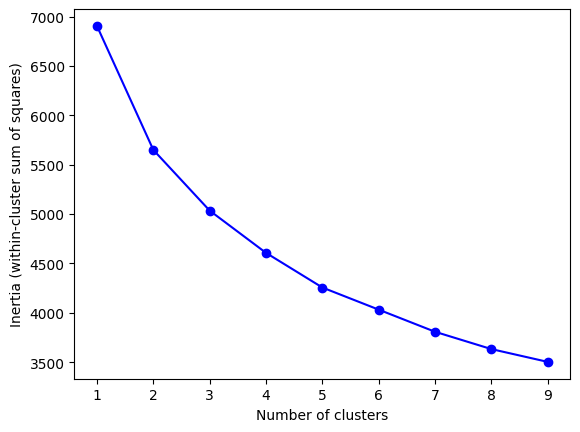

In [244]:
# IDENTIFICO MIGLIORE NUMERO DI CLASSI -> con valori standard

Ks = range(1, 10)
# KMeans(i) RUN THE ALGORITM WITH i CLUSTERS
# FALLO SUL DATA SET X
# POI CALCOLA  L'INERTIA
inertia = [KMeans(n_clusters=i, n_init=10).fit(X_DATA).inertia_ for i in Ks]

fig = plt.figure()
plt.plot(Ks, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.show()


In [245]:
# Controllo anche con silhoutte
range_n_clusters=[2,3,4,5,6,7,8,9,10]
for n_clusters in range_n_clusters:
    clusterer=KMeans(n_clusters=n_clusters, n_init = 10,random_state=0)
    # COSì OTTENGO I LABEL
    cluster_labels=clusterer.fit_predict(X_DATA)
    # compio la silhouette everage score
    silhouette_avg=silhouette_score(X_DATA,cluster_labels)
    print("For n_clusters=", n_clusters,
          "The average silhouette_score is :", silhouette_avg)



For n_clusters= 2 The average silhouette_score is : 0.18068653851820557
For n_clusters= 3 The average silhouette_score is : 0.17881100147360096
For n_clusters= 4 The average silhouette_score is : 0.16091866137048627
For n_clusters= 5 The average silhouette_score is : 0.1561690658348974
For n_clusters= 6 The average silhouette_score is : 0.1549594913849628
For n_clusters= 7 The average silhouette_score is : 0.15993808620933733
For n_clusters= 8 The average silhouette_score is : 0.16944355448267862
For n_clusters= 9 The average silhouette_score is : 0.17152737103516819
For n_clusters= 10 The average silhouette_score is : 0.17314929353178804


In [246]:
# clustering
k = 3
kmeans = KMeans(n_clusters=k, n_init = 10,random_state=0)
kmeans.fit(X_DATA)

# print inertia & cluster center
# print("inertia for k=3 is", kmeans.inertia_)
# print("cluster centers: ", kmeans.cluster_centers_)

# take a quick look at the result
y = kmeans.labels_
centers = kmeans.cluster_centers_
#print("cluster labels: ", y, centers)

print(centers.shape)
print(PC.shape)

NEW_CENTERS = np.dot(centers, PC)

print(NEW_CENTERS.shape)
print(NEW_CENTERS)

(3, 17)
(17, 3)
(3, 3)
[[ 0.15933406  0.28319114 -0.28221987]
 [-0.27783978  0.59372946 -0.60620265]
 [-0.01163133  0.14710856 -0.70607228]]


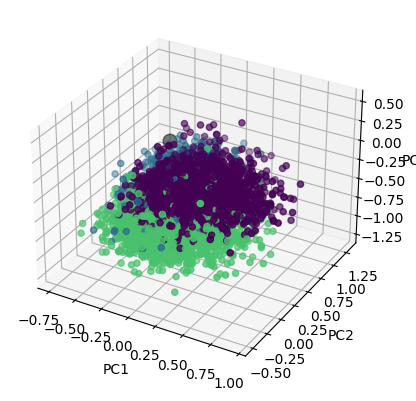

In [247]:
# visualizzazione grafica
# set up the color
norm = clrs.Normalize(vmin=0.,vmax=y.max() + 0.8)
cmap = cm.viridis

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#  X.iloc[:,1] vado a prendere tutte le righe della colonna 1 partendo a 0 per le colonne
# utilizza l'ordine della matrice X e Y per mapapre i coliri ai punti
ax.scatter(NEW_DATA[:,0], NEW_DATA[:,1], NEW_DATA[:,2], c=cmap(norm(y)), marker='o')

centers = kmeans.cluster_centers_

# PER VEDERE DOVE STANNO I CLUSTER PUNTI DI CENTRO
ax.scatter(NEW_CENTERS[:, 0], NEW_CENTERS[:, 1],c='black', s=100, alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC2')

plt.show()

Index(['Age', 'Gender', 'Job', 'Area', 'CitySize', 'FamilySize', 'Income',
       'Wealth', 'Debt', 'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle',
       'Luxury', 'Saving', 'Investments'],
      dtype='object')
(5000, 17)


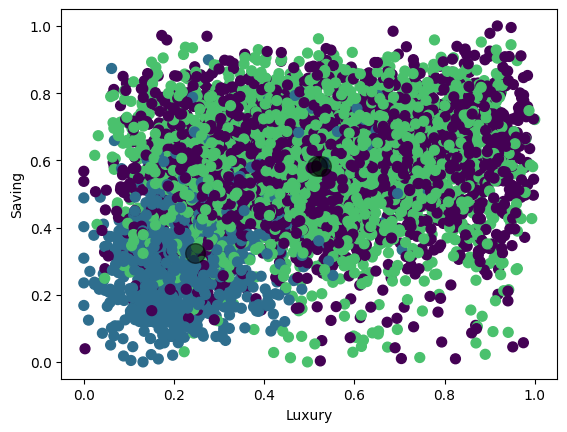

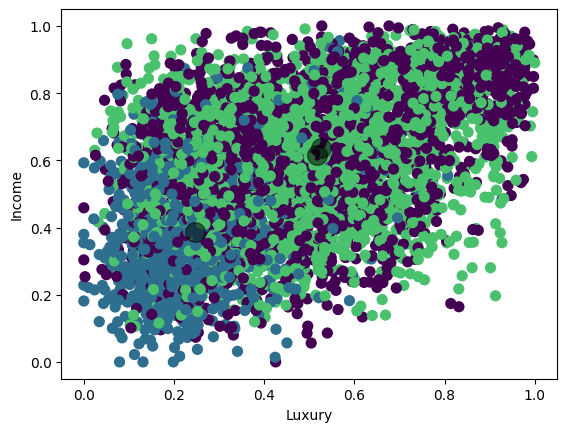

In [248]:
# VI SUALIZZAZIONE A 2 DIMENSIONI
figs = [(14, 15), (14, 6)]
labels = df_new.columns

print(labels)

norm = clrs.Normalize(vmin=0.,vmax=y.max() + 0.8)
cmap = cm.viridis

print(X_DATA.shape)
for i in range(2):
    fig = plt.figure(i)
    plt.scatter(X_DATA[:,figs[i][0]], X_DATA[:,figs[i][1]], c=cmap(norm(y)), s=50)
    plt.scatter(centers[:, figs[i][0]], centers[:, figs[i][1]], c='black', s=200, alpha=0.5)
    plt.xlabel(labels[figs[i][0]])
    plt.ylabel(labels[figs[i][1]])

plt.show()